In [44]:
import os
import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

In [45]:
label_path = '/kaggle/input/water-segmentation-dataset/data/labels/0.png'

# Load the image using PIL and convert it to a numpy array
with Image.open(label_path) as label:
    label_np = np.array(label)

# Find and print unique pixel values in the label
unique_values = np.unique(label_np)
print(f"Unique pixel values in the label: {unique_values}")

Unique pixel values in the label: [0 1]


In [46]:
images_path = '/kaggle/input/water-segmentation-dataset/data/images'
labels_path = '/kaggle/input/water-segmentation-dataset/data/labels'

#Load and preprocess (images & labels)
def load_data(images_path, labels_path):
    images = []
    labels = []
    for filename in os.listdir(images_path):
        if filename.endswith('.tif'):  
            image = tiff.imread(os.path.join(images_path, filename))
            image = tf.image.resize(image, [128, 128])
            image = image / 65535.0  #Normalize to [0, 1] (16-bit images)

            label_filename = filename.replace('.tif', '.png') 
            label = tf.io.read_file(os.path.join(labels_path, label_filename))
            label = tf.image.decode_png(label, channels=1) 
            label = tf.image.resize(label, [128, 128]) 
            label = tf.cast(label, tf.int32)  # Convert label to int

            images.append(image)
            labels.append(label)

    # Convert lists to TensorFlow tensors
    images = tf.convert_to_tensor(np.array(images))
    labels = tf.convert_to_tensor(np.array(labels))
    return images, labels

images, labels = load_data(images_path, labels_path)

In [47]:
# Create dataset
def create_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

training_data = create_dataset(images, labels)

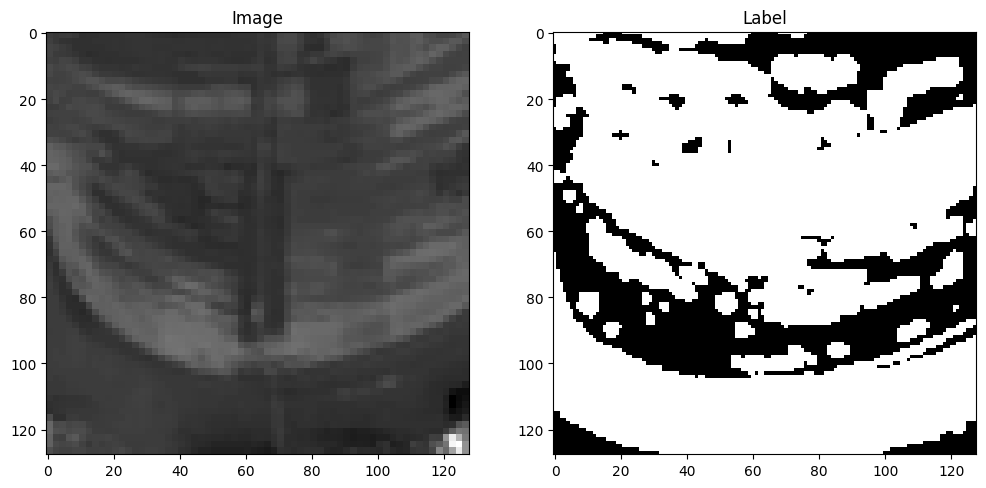

In [48]:
def visualize_sample(image, label):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image[..., 0], cmap='gray') 
    plt.subplot(1, 2, 2)
    plt.title('Label')
    plt.imshow(label[..., 0], cmap='gray')
    plt.show()

visualize_sample(images[0], labels[0])

In [49]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('unet_model.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]


In [50]:
images_np = images.numpy()
labels_np = labels.numpy()

X_train, X_test, y_train, y_test = train_test_split(images_np, labels_np, test_size=0.2, random_state=42)

In [51]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv4))
    concat5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv5))
    concat6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(layers.UpSampling2D((2, 2))(conv6))
    concat7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)


    model = Model(inputs=[inputs], outputs=[outputs])

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = unet_model()

In [52]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      6,976 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_24[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    524,544 │ up_sampling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_26[0][0],  │
│ (Concatenate)       │ 512)              │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_27[0][0] 

 Total params: 7,702,529 (29.38 MB)

 Trainable params: 7,702,529 (29.38 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=16, 
                    validation_split=0.1,                 
                    callbacks=callbacks)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 514ms/step - accuracy: 0.7481 - loss: 1.4322 - val_accuracy: 0.7636 - val_loss: 0.6660
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.7380 - loss: 0.6360 - val_accuracy: 0.7636 - val_loss: 0.4620
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.8004 - loss: 0.4376 - val_accuracy: 0.9034 - val_loss: 0.4154
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.8985 - loss: 0.3046 - val_accuracy: 0.9077 - val_loss: 0.3130
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.9019 - loss: 0.2858 - val_accuracy: 0.9147 - val_loss: 0.3103
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.9082 - loss: 0.2631 - val_accuracy: 0.9151 - val_loss: 0.2947
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.9126 - loss: 0.2546 - val_accuracy: 0.9167 - val_loss: 0.3142
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9080 - loss: 0.2442 - val_accuracy: 0

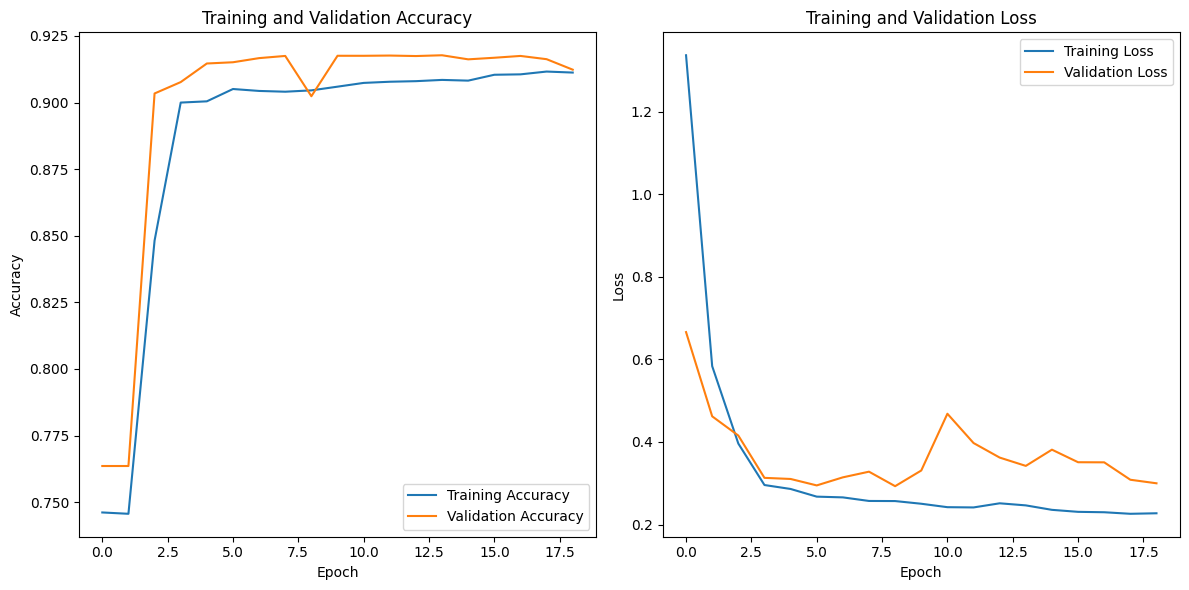

In [54]:
history_dict = history.history

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


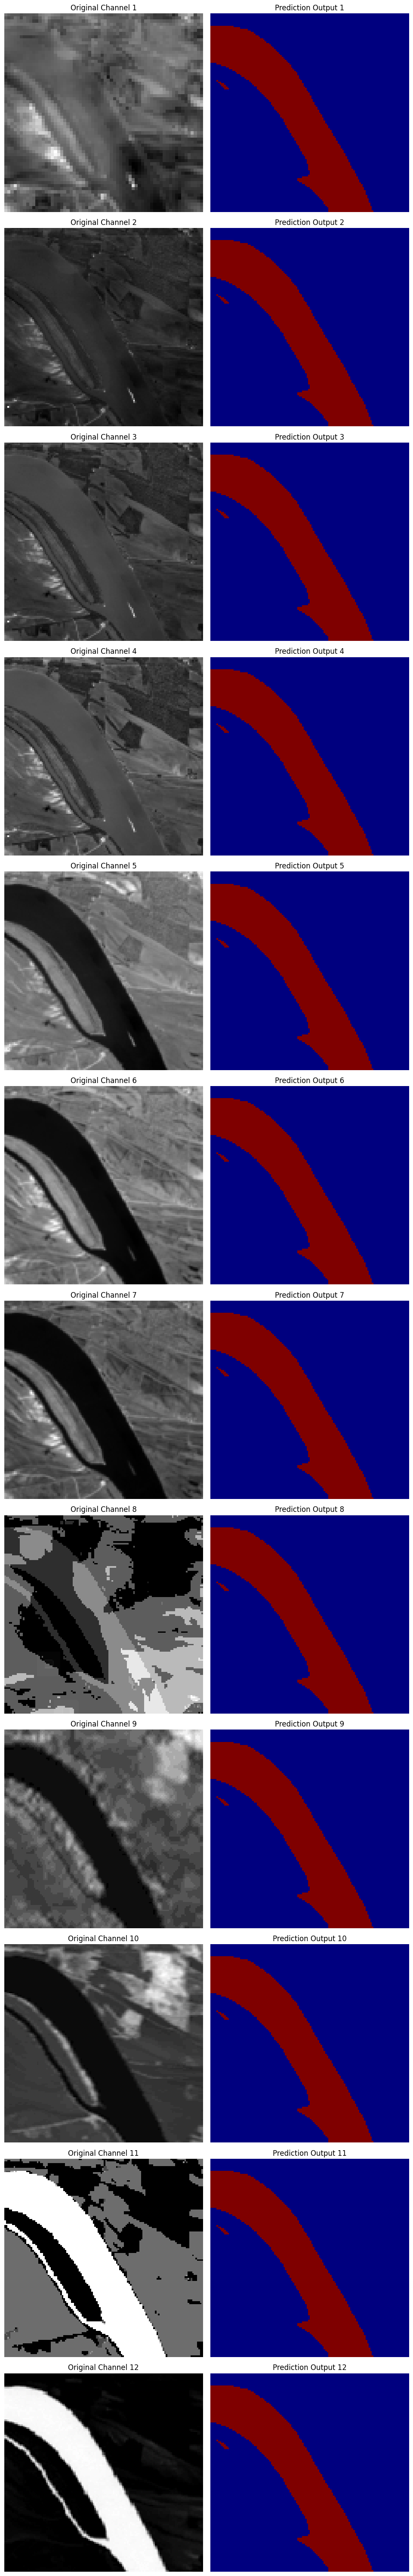

In [55]:
import tifffile as tiff
import matplotlib.pyplot as plt

image_path = '/kaggle/input/water-segmentation-dataset/data/images/277.tif'
image_array = tiff.imread(image_path).squeeze()

prediction_result = model.predict(image_array.reshape(1, 128, 128, 12)).squeeze()

num_channels = image_array.shape[2]
fig, axes = plt.subplots(num_channels, 2, figsize=(10, 5 * num_channels))

for i in range(num_channels):
    axes[i, 0].imshow(image_array[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Channel {i + 1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(prediction_result, cmap='jet')
    axes[i, 1].set_title(f'Prediction Output {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

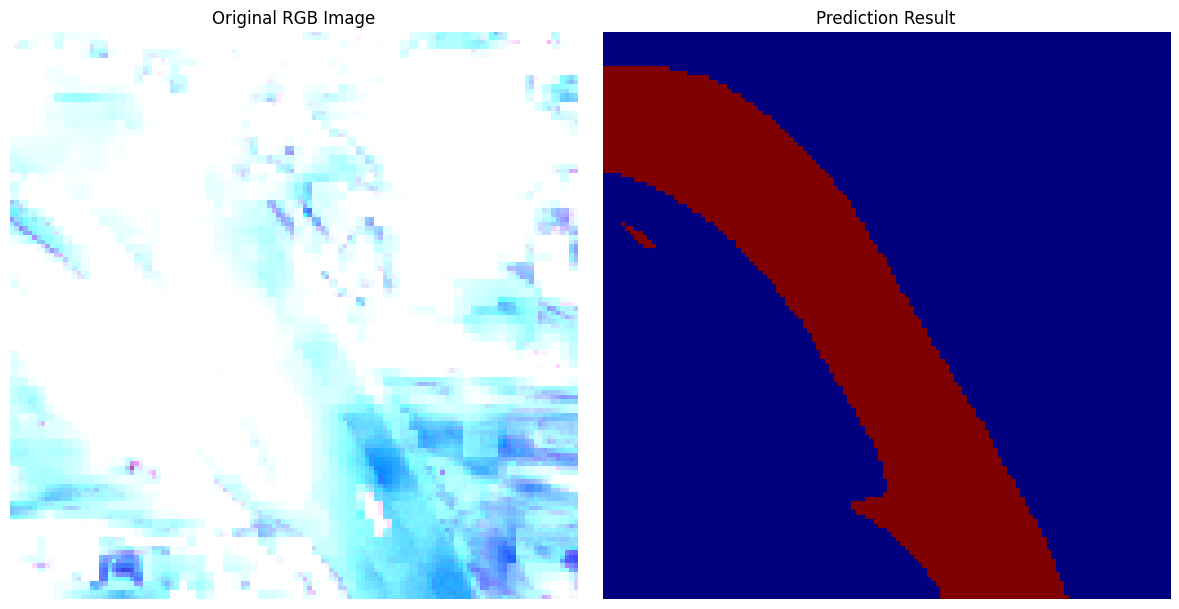

In [56]:
rgb_image = np.stack([image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(rgb_image)
axes[0].set_title('Original RGB Image')
axes[0].axis('off')

axes[1].imshow(prediction_result, cmap='jet')
axes[1].set_title('Prediction Result')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [57]:
model.save('my_model.keras')